In [51]:
import pandas as pd
from google.colab import drive
import yfinance as yf
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [9]:
company_tweet = pd.read_csv('/content/drive/MyDrive/Company_Tweet.csv')

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Set the start and end dates
start_date = "2014-12-31"
end_date = "2016-03-28"

# Define the tickers we want to get data for
tickers = ["MSFT", "TSLA", "AAPL", "AMZN", "GOOG"]

# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=tickers)

# Loop through each ticker and get the data
for ticker in tickers:
    # Use yfinance to get the historical data for the specified date range
    ticker_data = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate the percentage change from the opening price for each day
    ticker_data["Price_Change"] = (ticker_data["Close"] - ticker_data["Open"]) / ticker_data["Open"] * 100
    
    # Add the daily percentage changes to the results dataframe
    results_df[ticker] = ticker_data["Price_Change"]

# Print the results
results_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MSFT,TSLA,AAPL,AMZN,GOOG
Date,,,,,
2014-12-31,-0.599184,-0.304813,-2.162739,-0.385174,-0.912943
2015-01-02,0.214313,-1.597337,-1.849356,-1.298868,-0.793936
2015-01-05,-0.086256,-2.078772,-1.883831,-1.569983,-1.794517
2015-01-06,-1.573953,0.580785,-0.262811,-2.299502,-2.532040
2015-01-07,0.543715,-1.124918,0.513063,0.309241,-1.163704
...,...,...,...,...,...
2016-03-18,-2.603781,1.588829,-0.394958,-1.579494,-0.574225
2016-03-21,1.145541,1.266253,-0.018877,0.923649,0.758993
2016-03-22,0.858047,-1.252055,1.396676,2.819612,0.446119


In [10]:
copy = results_df.copy()
for i in tickers:
  copy[i] = results_df[i].apply(lambda x: 'Negative' if x < -0.5 else ('Positive' if x > 0.5 else 'Neutral'))

In [12]:
copy

,MSFT,TSLA,AAPL,AMZN,GOOG
Date,,,,,
2014-12-31,Negative,Neutral,Negative,Neutral,Negative
2015-01-02,Neutral,Negative,Negative,Negative,Negative
2015-01-05,Neutral,Negative,Negative,Negative,Negative
2015-01-06,Negative,Positive,Neutral,Negative,Negative
2015-01-07,Positive,Negative,Positive,Neutral,Negative
...,...,...,...,...,...
2016-03-18,Negative,Positive,Neutral,Negative,Negative
2016-03-21,Positive,Positive,Neutral,Positive,Positive
2016-03-22,Positive,Negative,Positive,Positive,Neutral


In [14]:
labels = pd.read_csv('tweet_labels.csv')

In [15]:
df = pd.read_pickle('/content/test_tweet_embeddings.pkl')

In [16]:
df = df.merge(labels, on = 'tweet_id', how = 'left')

In [17]:
df = df.merge(company_tweet, on = 'tweet_id', how = 'left')

In [18]:
counts = df.groupby(['date', 'ticker_symbol', 'labels']).count()[['body']]
counts.columns = ['number_of_tweets']
counts.reset_index(inplace = True)

In [19]:
counts

,date,ticker_symbol,labels,number_of_tweets
0,2015-01-01,AAPL,negative,26
1,2015-01-01,AAPL,neutral,115
2,2015-01-01,AAPL,positive,42
3,2015-01-01,AMZN,negative,35
4,2015-01-01,AMZN,neutral,30
...,...,...,...,...
7891,2016-03-28,MSFT,neutral,74
7892,2016-03-28,MSFT,positive,11
7893,2016-03-28,TSLA,negative,2
7894,2016-03-28,TSLA,neutral,27


In [20]:
# group by date and ticker_symbol, and find the index of the max value for each label
idx = counts.groupby(['date', 'ticker_symbol'])['number_of_tweets'].idxmax()

# select the rows with the max value for each label
result = counts.loc[idx, ['date', 'ticker_symbol', 'labels', 'number_of_tweets']]

In [29]:
appl_predictions = result.loc[result['ticker_symbol'] == 'AAPL'].reset_index(drop = True)

In [22]:
copy.reset_index(inplace = True)

In [30]:
appl_price = copy[['Date', 'TSLA']]
appl_price

,Date,TSLA
0,2014-12-31,Neutral
1,2015-01-02,Negative
2,2015-01-05,Negative
3,2015-01-06,Positive
4,2015-01-07,Negative
...,...,...
305,2016-03-18,Positive
306,2016-03-21,Positive
307,2016-03-22,Negative
308,2016-03-23,Negative


In [33]:
appl_predictions['date'] = appl_predictions['date'].astype(str)
appl_price['Date'] = appl_price['Date'].astype(str)

In [40]:
appl_agg = appl_predictions.merge(appl_price, left_on = 'date', right_on = 'Date', how = 'inner')

In [44]:
appl_agg

,date,ticker_symbol,labels,number_of_tweets,Date,True Share Price Reflection
0,2015-01-02,AAPL,neutral,340,2015-01-02,negative
1,2015-01-05,AAPL,neutral,348,2015-01-05,negative
2,2015-01-06,AAPL,neutral,369,2015-01-06,positive
3,2015-01-07,AAPL,neutral,311,2015-01-07,negative
4,2015-01-08,AAPL,neutral,455,2015-01-08,negative
...,...,...,...,...,...,...
301,2016-03-18,AAPL,neutral,509,2016-03-18,positive
302,2016-03-21,AAPL,neutral,2349,2016-03-21,positive
303,2016-03-22,AAPL,neutral,1278,2016-03-22,negative
304,2016-03-23,AAPL,neutral,671,2016-03-23,negative


In [42]:
appl_agg['TSLA'] = appl_agg['TSLA'].str.lower()

In [43]:
appl_agg['True Share Price Reflection'] = appl_agg['TSLA']
appl_agg.drop('TSLA', axis = 1, inplace = True)

In [45]:
appl_agg['Predicted Fluctuation'] = appl_agg['labels']
appl_agg.drop('labels', axis = 1, inplace = True)

In [47]:
appl_agg.drop('Date', axis = 1, inplace = True)
appl_agg

,date,ticker_symbol,number_of_tweets,True Share Price Reflection,Predicted Fluctuation
0,2015-01-02,AAPL,340,negative,neutral
1,2015-01-05,AAPL,348,negative,neutral
2,2015-01-06,AAPL,369,positive,neutral
3,2015-01-07,AAPL,311,negative,neutral
4,2015-01-08,AAPL,455,negative,neutral
...,...,...,...,...,...
301,2016-03-18,AAPL,509,positive,neutral
302,2016-03-21,AAPL,2349,positive,neutral
303,2016-03-22,AAPL,1278,negative,neutral
304,2016-03-23,AAPL,671,negative,neutral


In [48]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82827 sha256=18aaabce636b631c912faebc825596227b01ebfa038af0aa6e6f2497f37e316d
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55510 sha256=a35f557ce19c94a33556e254a80b5d5caf1f0ad1b5d1535ceb411b2c6b25bada
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [52]:
small_mat = appl_agg.loc[(appl_agg['Predicted Fluctuation'] != 'neutral') & (appl_agg['True Share Price Reflection'] != 'neutral')]
cf_matrix = confusion_matrix(small_mat['True Share Price Reflection'], small_mat['Predicted Fluctuation'])

In [54]:
import seaborn as sns
sns.heatmap(cf_matrix, annot = True)

ValueError: ignored

In [57]:
appl_agg.loc[(appl_agg['Predicted Fluctuation'] != 'neutral') & (appl_agg['True Share Price Reflection'] != 'neutral')]

,date,ticker_symbol,number_of_tweets,True Share Price Reflection,Predicted Fluctuation


In [ ]:
appl_agg['Predicted Fluctuation'].value_counts(normalize = True)

neutral     0.928803
positive    0.067961
negative    0.003236
Name: Predicted Fluctuation, dtype: float64

In [ ]:
appl_agg.loc[(appl_agg['Predicted Fluctuation'] == 'negative') & (appl_agg['True Share Price Reflection'] == 'negative')]

,date,ticker_symbol,number_of_tweets,True Share Price Reflection,Predicted Fluctuation


In [ ]:
from datetime import datetime

appl_predictions['date'] = appl_predictions['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').date())

In [ ]:
appl_predictions['date'] = pd.to_datetime(appl_predictions['date'])

In [ ]:
appl_predictions.dtypes

date                datetime64[ns]
ticker_symbol               object
labels                      object
number_of_tweets             int64
dtype: object

In [ ]:
import pandas as pd
df = pd.read_pickle('/content/test_tweet_embeddings.pkl')

In [ ]:
preds = pd.read_csv('/content/tweet_labels.csv')

In [ ]:
df['labels'] = preds['labels']

In [ ]:
df[['embeddings', 'labels']].to_pickle('/content/drive/MyDrive/sample.pkl')

In [58]:
# Assuming your DataFrame is called "df"
embeddings = df['embeddings'].tolist()[:100]
labels = df['labels'].tolist()[:100]


# Perform UMAP to reduce the dimensions of the embeddings to 2
reducer = umap.UMAP()
embedding_reduced = reducer.fit_transform(embeddings)

# Create a scatter plot of the reduced embeddings, color-coded by labels
# plt.scatter(embedding_reduced[:,0], embedding_reduced[:,1], c=labels)
# plt.show()

In [60]:
colors = df['labels'].replace({'neutral' : 'brown', 'positive' : 'blue', 'negative': 'red'}).tolist()[:100]

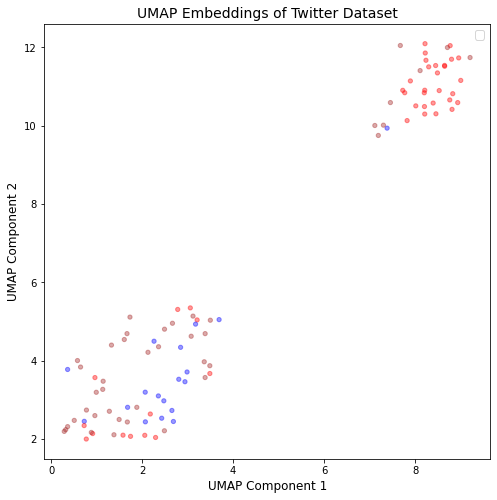

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(embedding_reduced[:,0], embedding_reduced[:,1], c = colors, alpha = 0.4, s = 18, facecolors='none')
ax.set_xlabel('UMAP Component 1', fontsize=12)
ax.set_ylabel('UMAP Component 2', fontsize=12)
ax.set_title('UMAP Embeddings of Twitter Dataset', fontsize=14)
ax.legend(loc='best', fontsize=12)
ax.legend(fontsize=12)
plt.show()

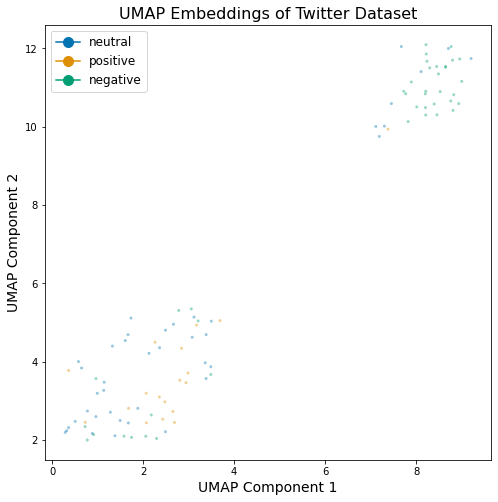

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# define color scheme
palette = sns.color_palette('colorblind')

# map labels to colors in the palette
label_to_color = {'neutral': palette[0], 'positive': palette[1], 'negative': palette[2]}
colors = df['labels'].map(label_to_color)[:100]

# create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(embedding_reduced[:,0], embedding_reduced[:,1], c=colors, alpha=0.4, s=9, edgecolors='none')
ax.set_xlabel('UMAP Component 1', fontsize=14)
ax.set_ylabel('UMAP Component 2', fontsize=14)
ax.set_title('UMAP Embeddings of Twitter Dataset', fontsize=16)

# create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in label_to_color.items()]
ax.legend(handles=legend_elements, loc='best', fontsize=12)

plt.savefig('scatter_plot.png') 
plt.show()


In [ ]:
# save plot as png file

<Figure size 432x288 with 0 Axes>

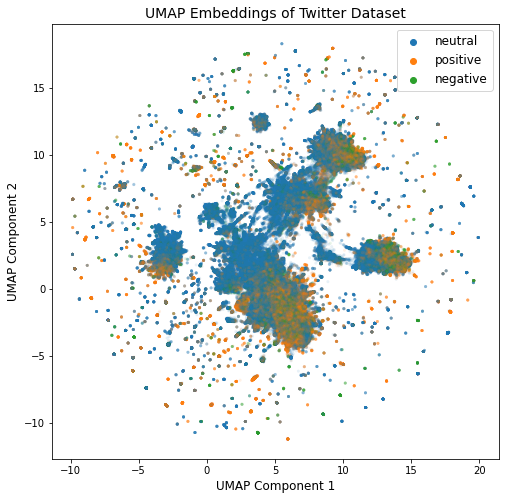

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colorblind-friendly color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Replace label names with color codes
color_dict = {'neutral': colors[0], 'positive': colors[1], 'negative': colors[2]}
df['colors'] = df['labels'].map(color_dict)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embedding_reduced[:, 0], y=embedding_reduced[:, 1], hue=df['labels'], palette=colors, alpha=0.1, s=9, edgecolor='none', ax=ax)

# Set plot properties
ax.set_xlabel('UMAP Component 1', fontsize=12)
ax.set_ylabel('UMAP Component 2', fontsize=12)
ax.set_title('UMAP Embeddings of Twitter Dataset', fontsize=14)

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='best', fontsize=12)

plt.show()
